# LangGraph Tutorials
https://langchain-ai.github.io/langgraph/tutorials/get-started

## Build the chatbot

In [4]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [ ]:
import os
from langchain.chat_models import init_chat_model

# Load .env
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

In [7]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [8]:
graph_builder.add_edge(START, "chatbot")

In [9]:
graph = graph_builder.compile()

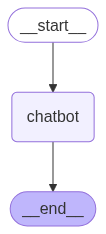

In [10]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Run the chatbot

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 你好👋！我是人工智能助手智谱清言，可以叫我小智🤖，很高兴见到你，欢迎问我任何问题。
Assistant: 我不是一个公司，我是一个人工智能助手，由清华大学 KEG 实验室和智谱 AI 共同开发而成。我旨在为用户提供客观的信息，完成用户提出的任务，让人们更加方便地获得他们所需要的知识和答案。
Goodbye!


## Tool

In [1]:
from langchain_tavily import TavilySearch

from dotenv import load_dotenv
load_dotenv()

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [ ]:
from langchain.chat_models import init_chat_model

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

llm_with_tools = llm.bind_tools(tools)

def chatbot_with_tools(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder = StateGraph(State)
graph_builder.add_node("chatbot_with_tools", chatbot_with_tools)

In [18]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

In [19]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools_with_tools", tool_node)

In [ ]:
from langgraph.graph import StateGraph, START, END

def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools_with_tools"
    return END

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_edge(START, "chatbot_with_tools")
graph_builder.add_conditional_edges(
    "chatbot_with_tools",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools_with_tools": "tools_with_tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools_with_tools", "chatbot_with_tools")
graph = graph_builder.compile()

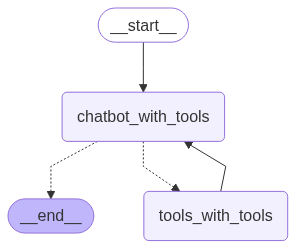

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: {"query": "\u4f60\u597d\u82f1\u8bed\u600e\u4e48\u8bf4", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "\u4e0d\u8981\u6c38\u8fdc\u53ea\u4f1a\u8bf4\"hello\"\uff0c\u8fd9\u91cc\u670940\u4e2a\u7528\u82f1\u8bed\u8bf4\"hello\"\u7684\u65b9\u5f0f\u548c\u6b63\u786e\u7684\u56de\u5e94\u65b9\u5f0f\uff08\u5efa\u8bae\u6536\u85cf\uff09 - \u7ea2\u677f\u7816\u5916\u8d38\u5f00\u53d1\u4fe1", "url": "https://hongbanzhuan.com/40-ways-to-say-hello/", "content": "\u9664\u4e86\"hello\"\u548c\"how are you\"\uff0c\u4f60\u8fd8\u53ef\u4ee5\u7528\u54ea\u4e9b\u82f1\u8bed\u95ee\u5019\u548c\u56de\u5e94\u4f60\u7684\u5bf9\u8bdd\u4f19\u4f34\uff1f\u8fd9\u7bc7\u6587\u7ae0\u4ecb\u7ecd\u4e8640\u79cd\u4e0d\u540c\u7684\u82f1\u8bed\u95ee\u5019\u65b9\u5f0f\u548c\u56de\u5e94\u65b9\u5f0f\uff0c\u5305\u62ec\u6b63\u5f0f\u3001\u975e\u6b63\u5f0f\u3001\u4eb2\u5bc6\u3001\u4fda\u8bed\u7b49\u573a\u5408\u7684\u7528\u6cd5\u3002\u4f60\u8fd8\u53ef\u4ee5\u5b66\u4e60\u5982\u4f55\u6839\u63

## Memory

In [24]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [26]:
graph = graph_builder.compile(checkpointer=memory)

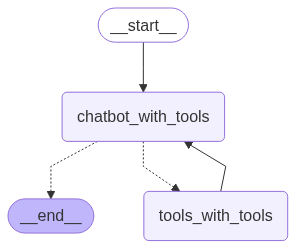

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello, Will! How can I assist you today?


In [31]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember your name is Will. How can I help you?


In [32]:
# Different config
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is ZhiPuQingYan（智谱清言）, a language model jointly trained by KEG Lab of Tsinghua University and Zhipu AI.


In [35]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='cf5428c2-bc9f-437e-8029-4fccd112af07'), AIMessage(content='Hello, Will! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 1218, 'total_tokens': 1231, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'glm-4', 'system_fingerprint': None, 'id': '202506091812157f835d005a5745d7', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--ac89d102-1eb1-465d-b765-c1c09f19a334-0', usage_metadata={'input_tokens': 1218, 'output_tokens': 13, 'total_tokens': 1231, 'input_token_details': {}, 'output_token_details': {}}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2ffd3c3e-4de8-48f1-ae7f-f9a295e69ec8'), AIMessage(content='Yes, I remember your name is Will. How can I help you?', addi

In [ ]:
snapshot.next # END

()

## Human-in-the-loop

In [37]:
import os
from langchain.chat_models import init_chat_model

# Load .env
from dotenv import load_dotenv
load_dotenv()

llm = init_chat_model(
    "openai:glm-4-plus",
    base_url="https://open.bigmodel.cn/api/paas/v4"
)

In [ ]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langgraph.types import Command, interrupt

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Because we will be interrupting during tool execution,
    # we disable parallel tool calling to avoid repeating any
    # tool invocations when we resume.
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")